In [9]:
import pandas as pd
from pyAgrum import BNLearner, BayesNet, LabelizedVariable, LazyPropagation

from pyAgrum.lib.notebook import showBN, showInference, showPotential, showGraph
from pyAgrum.lib.bn_vs_bn import GraphicalBNComparator

In [10]:
def _read_data(filename: str = "./both_test_balanced.csv"):
    df = pd.read_csv(filename)

    # Rename columns and drop unused columns
    df.columns = [
        (col.replace("Symptom-", "S_").replace(" ", "").strip()) for col in df.columns
    ]
    df.rename(columns={"Class": "Positive"}, inplace=True)
    df.drop(["Areyouahealthprofessional?", "Gender"], inplace=True, axis=1)

    # Format/Adjust values
    columns = [
        "S_ThroatPain",
        "S_Dyspnea",
        "S_Fever",
        "S_Cough",
        "S_Headache",
        "S_TasteDisorders",
        "S_OlfactoryDisorders",
        "S_Coryza",
        "Positive",
    ]
    df[columns] = df[columns].apply(lambda col: (col * -1) + 1)
    return df


def _learn_bn(df, base_bn, algorithm, *args, **kwargs):
    learner = BNLearner(df, base_bn)
    algorithm(learner, *args, **kwargs)
    return learner.learnBN()


def _show_posterior(bn, target, evs=None):
    ie = LazyPropagation(bn)
    if evs:
        ie.setEvidence(evs)
    ie.makeInference()
    showPotential(ie.posterior(target))

In [11]:
## Load data from CSV using pandas
df = _read_data()
df.head(5)

,S_ThroatPain,S_Dyspnea,S_Fever,S_Cough,S_Headache,S_TasteDisorders,S_OlfactoryDisorders,S_Coryza,Positive
0,1,0,1,1,0,0,0,0,1
1,0,0,0,0,0,1,1,0,1
2,1,0,1,1,1,1,1,0,1
3,1,0,1,1,0,1,1,1,1
4,0,1,1,1,0,1,1,0,1


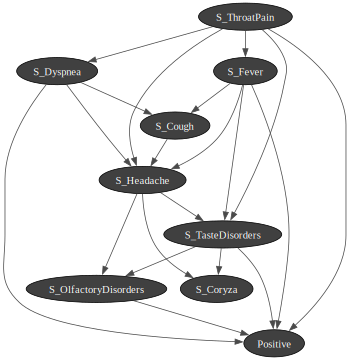

In [12]:
## Create a BN network from loaded data
# Create a base BN without any arcs (used when learning)
base_bn = BayesNet("Covid")
nodes = {col: base_bn.add(LabelizedVariable(col, col, 2)) for col in df.columns}

# Learn the BN network from data
bn = _learn_bn(df, base_bn, BNLearner.useK2, [*nodes.values()])
showBN(bn)

In [13]:
## Show conditional probabilities
showPotential(bn.cpt("S_Headache"))
showPotential(bn.cpt("Positive"))

In [14]:
## Show inference probabilities
_show_posterior(bn, "S_OlfactoryDisorders")
_show_posterior(bn, "S_OlfactoryDisorders", {"S_TasteDisorders": 1})
_show_posterior(
    bn, "Positive", {"S_OlfactoryDisorders": 1, "S_TasteDisorders": 1, "S_Fever": 0}
)

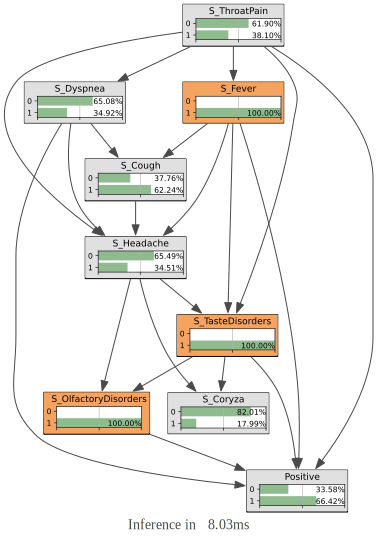

In [15]:
## Show inference graph
showInference(bn, evs={"S_OlfactoryDisorders": 1, "S_TasteDisorders": 1, "S_Fever": 1})

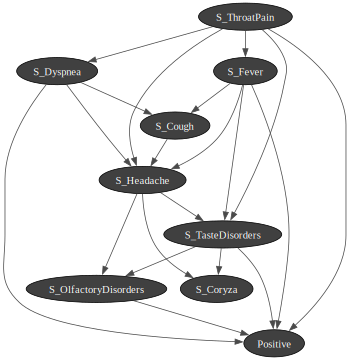

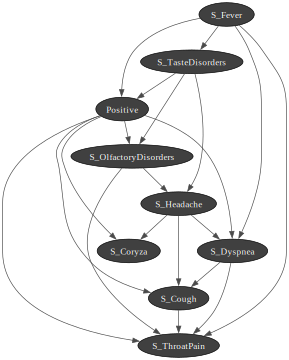

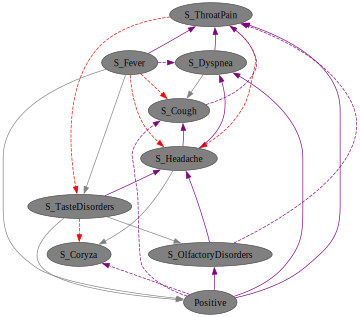

In [16]:
## Compare search algorithm
comp_bn1 = _learn_bn(df, base_bn, BNLearner.useK2, [*nodes.values()])
comp_bn2 = _learn_bn(df, base_bn, BNLearner.useGreedyHillClimbing)

showBN(comp_bn1)
showBN(comp_bn2)

comparator = GraphicalBNComparator(comp_bn1, comp_bn2)
showGraph(comparator.dotDiff())